In [1]:
import torch

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood

from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import RBFKernel, MaternKernel, ScaleKernel
from gpytorch.constraints import GreaterThan, LessThan

from gpytorch.models import ExactGP
from gpytorch.means import ZeroMean
from gpytorch.distributions import MultivariateNormal

from copy import deepcopy

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['font.family'] = 'sans-serif'
import vapeplot; vapeplot.set_palette('vaporwave')

In [2]:
class PriorGP(ExactGP):
    def __init__(self, covar_module, likelihood):
        super().__init__(None, None, likelihood)
        self.mean_module = ZeroMean()
        self.covar_module = covar_module
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        
        return MultivariateNormal(mean_x, covar_x)

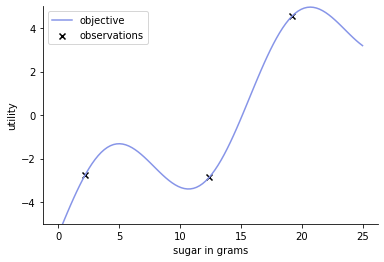

In [3]:
def f(x):
    return (torch.sin(x / 2.5) * 6 + x) / 2.5 - 5.5


x_test = torch.linspace(0, 25, 100)

# randomly selected observations
torch.manual_seed(0)
x_train = torch.rand(3, 1) * 25
y_train = f(x_train)

plt.plot(x_test, f(x_test), c='C1', label='objective')
plt.scatter(x_train, y_train, c='k', marker='x', label='observations')

plt.ylim(-5, 5)
plt.xlabel('sugar in grams')
plt.ylabel('utility')
plt.legend();

In [59]:
kernel = ScaleKernel(RBFKernel())
kernel.outputscale = 15
kernel.base_kernel.lengthscale = 2.5

gp = SingleTaskGP(
    x_train, y_train,
    likelihood=GaussianLikelihood(noise_constraint=LessThan(0.04)),
    covar_module=kernel
)

mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

# fit_gpytorch_model(mll);
gp.eval();

/Users/quannguyen/anaconda3/envs/preference_botorch/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


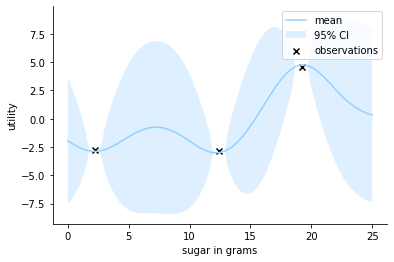

In [60]:
with torch.no_grad():
    output = gp(x_test)
    mean = output.mean
    lower, upper = output.confidence_region()
    
# plt.plot(x_test, f(x_test), c='C1', linestyle='--', label='objective')
    
plt.plot(x_test, mean, label='mean')
plt.fill_between(x_test, lower, upper, alpha=0.3, label='95% CI')

plt.scatter(x_train, y_train, c='k', marker='x', label='observations')

plt.xlabel('sugar in grams')
plt.ylabel('utility')
plt.legend();

In [43]:
gp.covar_module.outputscale, gp.covar_module.base_kernel.lengthscale

(tensor(12.2531, grad_fn=<SoftplusBackward>),
 tensor([[1.2635]], grad_fn=<SoftplusBackward>))

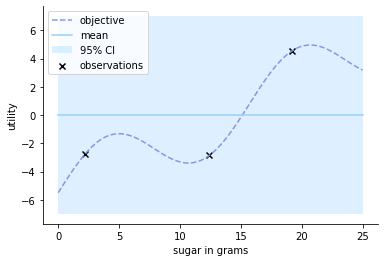

In [6]:
prior_gp = PriorGP(deepcopy(gp.covar_module), deepcopy(gp.likelihood))
prior_gp.eval()

with torch.no_grad():
    output = prior_gp(x_test)
    mean = output.mean
    lower, upper = output.confidence_region()
    
plt.plot(x_test, f(x_test), c='C1', linestyle='--', label='objective')
    
plt.plot(x_test, mean, label='mean')
plt.fill_between(x_test, lower, upper, alpha=0.3, label='95% CI')

plt.scatter(x_train, y_train, c='k', marker='x', label='observations')

plt.xlabel('sugar in grams')
plt.ylabel('utility')
plt.legend();